# Exploring the model code

The model code is contained in the `wals_ml_engine` directory. The code's 
high-level functionality is implemented by the following files:

`mltrain.sh`
 * Launches various types of ML Engine jobs. This shell
      script accepts arguments for the location of the dataset file, the
      delimiter used to separate values in the file, and whether the data
      file has a header line. It's a best practice to create a script that
      automatically configures and executes ML Engine jobs.

`task.py`
 * Parses the arguments for the ML Engine job and executes
      training.

`model.py`
 * Loads the dataset.
 * Creates two sparse matrices from the data, one for  training and one for
      testing. Executes WALS on the training sparse matrix of ratings.

`wals.py`
 * Creates the WALS model.
 * Executes the WALS algorithm.
 * Calculates the root-mean-square error [RMSE](https://wikipedia.org/wiki/Root-mean-square_deviation) for a set of row/column factors and a ratings matrix.

## Let's run some code

Now we will run some of the code from `model.py` in this notebook, to help you understand it.

**Execute the following cell to import necessary python modules:**

In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import tensorflow as tf

## The MovieLens data set

**Execute the following cell to download the MovieLens 100k data set:**

In [ ]:
!curl -O 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip ml-100k.zip
!mkdir -p ../data
!cp ml-100k/u.data ../data/

**Let's take a look at the MovieLens data.** It consists of rows of individual user ratings of movies.  Each row consists of four elements: a unique user id, a unique 'item id' corresponding to a movie, a rating from 1-5, and a timestamp of when the rating was made.  Each row of data maps to a single entry in the ratings matrix:

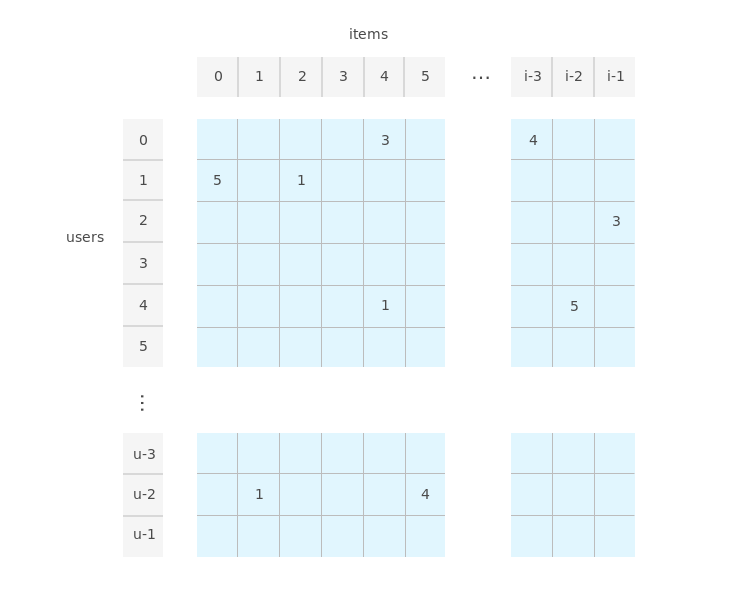

Let's inspect the contents of the file:

In [ ]:
!head ../data/u.data

This model ignores the timestamp.  We will only make use of the **user id**, **item** (or movie) **id**, and **rating**.

## How the model preprocesses data

The model code performs data preprocessing to create a sparse ratings matrix and prepare it for matrix factorization. 

**This involves the following steps:**

 * The model code loads rows of data from a delimited text file, in this case the MovieLens data. 

**Execute this cell to read the MovieLens data set into a Pandas dataframe:**

In [ ]:
input_file = '../data/u.data'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep='\t',
                         names=headers,
                         header=header_row,
                         dtype={
                           'user_id': np.int32,
                           'item_id': np.int32,
                           'rating': np.float32,
                           'timestamp': np.int32,
                         })

 * The code establishes a 0-indexed set of unique IDs for users and items. This guarantees that a unique ID corresponds to specific row and column indexes of the sparse ratings matrix.
 
**Let's find the number of unique users and movies:**

In [ ]:
np_users = ratings_df.user_id.as_matrix()
np_items = ratings_df.item_id.as_matrix()
unique_users = np.unique(np_users)
unique_items = np.unique(np_items)

n_users = unique_users.shape[0]
n_items = unique_items.shape[0]

In [ ]:
n_users

In [ ]:
n_items

The MovieLens 100k data uses 1-based IDs where the lowest index of the unique set is 1. But the TensorFlow code assumes a starting index of zero.  The code handles this **by converting the Pandas dataframe to a numpy array and subtracting one from each index:**

In [ ]:
ratings = ratings_df.as_matrix(['user_id', 'item_id', 'rating'])
ratings[:,0] -= 1
ratings[:,1] -= 1

In [ ]:
ratings

 * The model code randomly selects a test set of ratings. By default, 10% of the ratings are chosen for the test set. These ratings are removed from the training set and will be used to evaluate the predictive accuracy of the user and item factors.

In [ ]:
TEST_SET_RATIO = 10

test_set_size = len(ratings) / TEST_SET_RATIO
test_set_idx = np.random.choice(xrange(len(ratings)),
                                size=test_set_size, replace=False)
test_set_idx = sorted(test_set_idx)

ts_ratings = ratings[test_set_idx]
tr_ratings = np.delete(ratings, test_set_idx, axis=0)

In [ ]:
test_set_idx

In [ ]:
ts_ratings

In [ ]:
tr_ratings

 * Finally, the code creates a `scipy` sparse matrix in coordinate form (`coo_matrix`) that includes the user and item indexes and ratings. The `coo_matrix` object acts as a wrapper for a sparse matrix. It also performs validation of the user and ratings indexes, checking for errors in preprocessing:

In [ ]:
u_tr, i_tr, r_tr = zip(*tr_ratings)
tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

u_ts, i_ts, r_ts = zip(*ts_ratings)
test_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

In [ ]:
tr_sparse

In [ ]:
test_sparse

## How the WALS Algorithm is implemented in TensorFlow

You can read the [solution online](https://wikipedia.org/wiki/Root-mean-square_deviation) to understand how the WALS algorithm is implemented in TensorFlow.